# Name Service
### Ethereum Name Service

#### Imports
Import the necessary libraries to run the notebook. 

In [1]:
from web3 import Web3
import json
import requests
from datetime import datetime
from IPython.display import Image
from IPython.display import SVG
#from ens.auto import ns
from ens import ENS

#### Connection
Create a connection to the Ethereum network using the `web3` library and the Infura URL provided. Use the `ens` library to create an instance of the ENS object, passing in the `web3` object as an argument. Check if the connection to the Ethereum network is successful using the `web3.isConnected()` method. 

In [2]:
infura_url= 'https://mainnet.infura.io/v3/[YOUR API KEY]'
web3= Web3(Web3.HTTPProvider (infura_url))
web3.isConnected()
ns = ENS.fromWeb3(web3)

True

#### Retrieve the Owner Address of a Domain
Use the `ns.owner()` method from the `ENS` library to retrieve the owner address of a given domain. In this case, the domain is `sleeplessquant.eth`. 

In [5]:
owner_address = ns.owner('sleeplessquant.eth')
owner_address

'0x282EA59e790F6346A92c68011c3C517B764fc02e'

#### Retrieving the Domain Name of an Owner Address
The other way round. Use the `ns.name()` method from the `ENS` library to retrieve the domain name of a given owner address. 

In [6]:
domain_name = ns.name(owner_address)
domain_name

'sleeplessquant.eth'

#### Extract from Ethereum permanent registrar

Load the ABI stored in the `ethregistrar_abi.json` file. Use the `web3` library to create a contract instance from the Ethereum address stored in the `sc_address` variable and the ABI stored in the `ethregistrar_abi.json` file. 

In [7]:
sc_address="0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85"
with open ("./ethregistrar_abi.json") as f:
    abi= json.load (f)

In [8]:
ethregContract = web3.eth.contract(address=sc_address, abi=abi)

List all the functions available in the contract object created in the previous cell.

In [9]:
ethregContract.all_functions()

[<Function GRACE_PERIOD()>,
 <Function addController(address)>,
 <Function approve(address,uint256)>,
 <Function available(uint256)>,
 <Function balanceOf(address)>,
 <Function baseNode()>,
 <Function controllers(address)>,
 <Function ens()>,
 <Function getApproved(uint256)>,
 <Function isApprovedForAll(address,address)>,
 <Function isOwner()>,
 <Function nameExpires(uint256)>,
 <Function owner()>,
 <Function ownerOf(uint256)>,
 <Function reclaim(uint256,address)>,
 <Function register(uint256,address,uint256)>,
 <Function registerOnly(uint256,address,uint256)>,
 <Function removeController(address)>,
 <Function renew(uint256,uint256)>,
 <Function renounceOwnership()>,
 <Function safeTransferFrom(address,address,uint256)>,
 <Function safeTransferFrom(address,address,uint256,bytes)>,
 <Function setApprovalForAll(address,bool)>,
 <Function setResolver(address)>,
 <Function supportsInterface(bytes4)>,
 <Function transferFrom(address,address,uint256)>,
 <Function transferOwnership(address)>]

In [10]:
print ("The address owns " + str (ethregContract.functions.balanceOf(owner_address).call()) + " ENS NFTs")

The address owns 2 ENS NFTs


If we further analyse the minting transaction we will find the tokeID of the domain under analysis. Retrieve the event logs of such transaction and decode them. 

In [11]:
transaction='0x87105df5448143e32e68b3f61a089d5e9749760307913b2f1ac983c5137afab4'

In [12]:
%%capture --no-display
txreceipt= web3.eth.getTransactionReceipt (transaction)
abi_events = [abi for abi in ethregContract.abi if abi["type"] == "event"]
for event in abi_events:
    name = event["name"]
    inputs = [param["type"] for param in event["inputs"]]
    inputs = ",".join(inputs)
    event_abi_human = f"{name}({inputs})"
    event_abi_hex = web3.toHex(web3.keccak(text=event_abi_human))
    for l in range (0, len (txreceipt['logs'])):
        event_hex = web3.toHex(txreceipt['logs'][l]['topics'][0])
        if event_abi_hex == event_hex:
            decoded_logs = ethregContract.events[event["name"]]().processReceipt(txreceipt)

In [13]:
decoded_logs[0]

AttributeDict({'args': AttributeDict({'from': '0x0000000000000000000000000000000000000000',
  'to': '0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5',
  'tokenId': 75591461669745598647194783930100055739437187215861704932211984972603114828431}),
 'event': 'Transfer',
 'logIndex': 177,
 'transactionIndex': 72,
 'transactionHash': HexBytes('0x87105df5448143e32e68b3f61a089d5e9749760307913b2f1ac983c5137afab4'),
 'address': '0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85',
 'blockHash': HexBytes('0xa9a98f38ed88793fde3b00c0f38e577e24a6517e54f31f863d977e33b36b832b'),
 'blockNumber': 16306962})

Retrieve the token ID

In [14]:
tokenID=decoded_logs[0]['args']['tokenId']
tokenID

75591461669745598647194783930100055739437187215861704932211984972603114828431

In [15]:
registrar_add=decoded_logs[0]['address']
registrar_add

'0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85'

#### Retrieving Lease Expiration Date
Retrieve the lease expiration date from the Ethereum registrar contract. Access the specific `nameExpires` function, passing the `tokenID` as an argument. Converted the result to a timestamp, and then to a string in the format `YYYY-MM-DD HH:MM:SS`.

In [16]:
print ("The leasing expires on: " + str (ethregContract.functions.nameExpires(tokenID).call()))
print ("The leasing expires on: " + str (datetime.utcfromtimestamp (int(ethregContract.functions.nameExpires(tokenID).call())).strftime('%Y-%m-%d %H:%M:%S')))

The leasing expires on: 1798744247
The leasing expires on: 2026-12-31 19:10:47


#### Displaying the Image
Retrieve an image from the Ethereum registry contract that correspond to the tokenID. The format is SVG. 

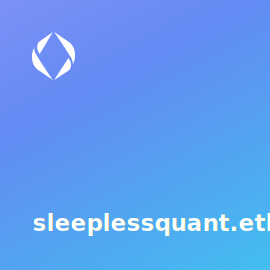

In [17]:
url_metadata= "https://metadata.ens.domains/mainnet/"+registrar_add+"/"+str(tokenID)
response = requests.get(url_metadata).json()
display (SVG(url= response["image"]))